In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sys  
sys.path.append('../')

import modules.data_wrangling.feature_selection as feature_selection
import modules.classification.probabilities as probabilities
import modules.propensity_score.propensity_score as propensity_score
#import modules.propensity_score.table_propensity_score_gender_effect as table_propensity_score_gender_effect

# Load data

In [2]:
df = pd.read_csv("..\..\output\df_cleaned.csv", sep=";")
df.head()

,ID,URL,DATE,YEAR,HQ,AUT_COMM,JUDGE_ID,JUDGE_ML,PLAIN_ML,DEFEN_ML,...,LN_JNPREF_b,LN_JNPREF,CD_JOINT,CD_JO_CF,WIN_SL,WINWIN,CD_FH_AT,CD_FH_SP,CD_MP_AT,CD_MP_SP
0,APA_2018_3010,http://labje.unizar.es/sentencias/APA_2018_301...,43362,2018,Alicante,Comunidad Valenciana,0,1,1,0,...,0,0.0,0,0,0,0,0,0,1,0
1,APA_2019_1490,http://labje.unizar.es/sentencias/APA_2019_149...,43621,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0
2,APA_2019_1497,http://labje.unizar.es/sentencias/APA_2019_149...,43607,2019,Alicante,Comunidad Valenciana,1,1,1,0,...,0,0.0,0,0,0,0,1,0,1,0
3,APA_2019_1500,http://labje.unizar.es/sentencias/APA_2019_150...,43600,2019,Alicante,Comunidad Valenciana,2,0,1,0,...,0,0.0,0,0,0,0,0,0,1,0
4,APA_2019_15542,http://labje.unizar.es/sentencias/APA_2019_155...,43818,2019,Barcelona,Cataluña,3,1,1,0,...,0,0.0,0,0,0,0,0,0,0,0


# Define functions

In [3]:
# COMPUTE WINNING PERCENTAGES PER BUCKET

def get_percentage_winning_bucket(df_bucket):
    # Get test_index for the bucket
    indices_bucket = list(df_bucket['test_index'])

    # Get only rows with test_index of df
    rows_bucket = df.iloc[indices_bucket]
    
    # Get percentage of winning sentences
    percentage_winning_cases = len(rows_bucket[rows_bucket['WINWIN'] == 1])/len(rows_bucket)
    
    return percentage_winning_cases

def get_percentage_winning_bucket_n_buckets(df_conf, num_buckets):
    # Split df into n buckets of equal size
    df_split = np.array_split(df_conf, num_buckets)

    percentages = []
    
    # Get percentage for each created bucket
    for bucket in df_split:
        percentage = get_percentage_winning_bucket(bucket)
        percentages.append(percentage)

    return percentages

In [4]:
def counfounding_plot(percentages, num_buckets):
    confounding_df = pd.DataFrame(columns = ['bucket', 'winning percentage'])

    bucket_ids = list(np.arange(1,num_buckets+1))    

    confounding_df['Gender probability'] = bucket_ids
    confounding_df['Winning probability'] = percentages 
    
    sns.barplot(x="Gender probability", y="Winning probability", data=confounding_df, palette=['#8c510a','#d8b365', '#5ab4ac','#01665e']) 

# Plaintiff

## Gender predictor

In [5]:
fc = feature_selection.features_classification_lists(file_name = r"..\..\data\features_classification.csv")
categorical_features = fc["Judicial resolution"] + ["HQ", "AUT_COMM","JUDGE_ID"]
hide_cols = categorical_features + ["PLAIN_ML", "DEFEN_ML"] + fc["Court decisions"]
print(hide_cols)

['ID', 'URL', 'DATE', 'YEAR', 'HQ', 'AUT_COMM', 'JUDGE_ID', 'PLAIN_ML', 'DEFEN_ML', 'CD_JOINT', 'CD_JO_CF', 'WIN_SL', 'WINWIN', 'CD_FH_AT', 'CD_FH_SP', 'CD_MP_AT', 'CD_MP_SP']


In [6]:
df_conf = probabilities.lr_classifier_conf(df, "PLAIN_ML", hide_cols)
df_conf = probabilities.conf_by_index(df_conf)
df_conf.head()

Balanced accuracy mean: 0.8504044546671345


,test_index,conf_1
0,0,0.929302
1,1,0.883444
2,2,0.971916
3,3,0.966186
4,4,0.867594


In [7]:
df_conf = df_conf.sort_values(by='conf_1')
df_conf

,test_index,conf_1
1343,1343,0.035976
1356,1356,0.044781
969,969,0.054478
550,550,0.060398
1879,1879,0.067095
...,...,...
1314,1314,0.978135
330,330,0.979723
1414,1414,0.979727
1239,1239,0.980301


## Propensity score

[0.14832535885167464, 0.19776714513556617, 0.18819776714513556]


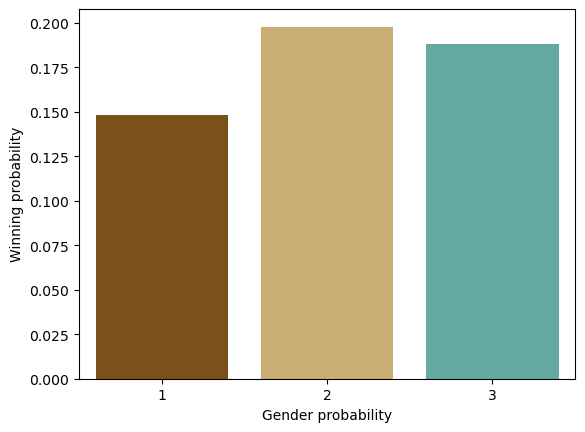

In [8]:
num_buckets = 3
percentages = get_percentage_winning_bucket_n_buckets(df_conf, num_buckets)
print(percentages)
counfounding_plot(percentages, num_buckets)

# Judge

## Gender predictor

In [9]:
df_conf_judge = probabilities.lr_classifier_conf(df, "JUDGE_ML", hide_cols)
df_conf_judge = probabilities.conf_by_index(df_conf_judge)
df_conf_judge.head()

Balanced accuracy mean: 0.5007656480448502


,test_index,conf_1
0,0,0.649299
1,1,0.627215
2,2,0.655725
3,3,0.649831
4,4,0.643602


In [10]:
df_conf_judge = df_conf_judge.sort_values(by='conf_1')
df_conf_judge

,test_index,conf_1
1797,1797,0.329396
263,263,0.433841
1270,1270,0.447217
1408,1408,0.459943
1844,1844,0.461364
...,...,...
136,136,0.775646
1770,1770,0.778459
1031,1031,0.779994
746,746,0.807877


## Propensity score

[0.215311004784689, 0.16108452950558214, 0.15789473684210525]


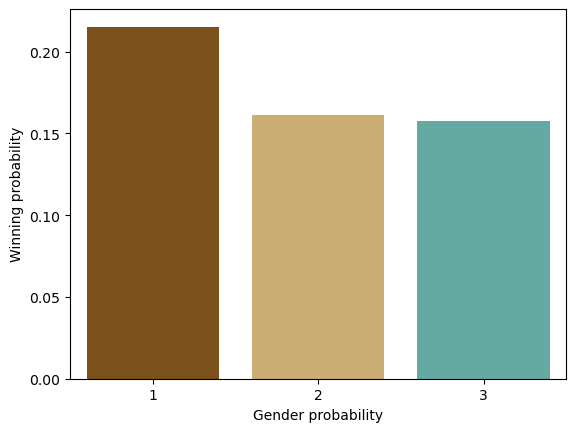

In [11]:
num_buckets = 3
percentages = get_percentage_winning_bucket_n_buckets(df_conf_judge, num_buckets)
print(percentages)
counfounding_plot(percentages, num_buckets)